# Clustering of the data

Le clustering consiste à regrouper un ensemble d'objet de telle sorte que les objets d'un même groupe (cluster) sont plus similaire entre eux qu'avec les autres groupes.

In [29]:
from sklearn.datasets import load_digits 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics

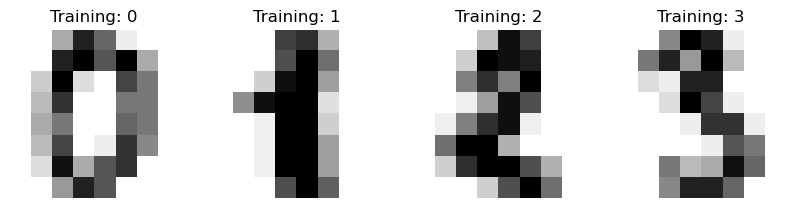

In [30]:
digits = load_digits()
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Training: {label}")

In [31]:
X, y = digits["data"], digits["target"]

In [32]:
X.shape

(1797, 64)

Il y a 1797 images de 8x8 pixels.

In [33]:
X /= X.max()

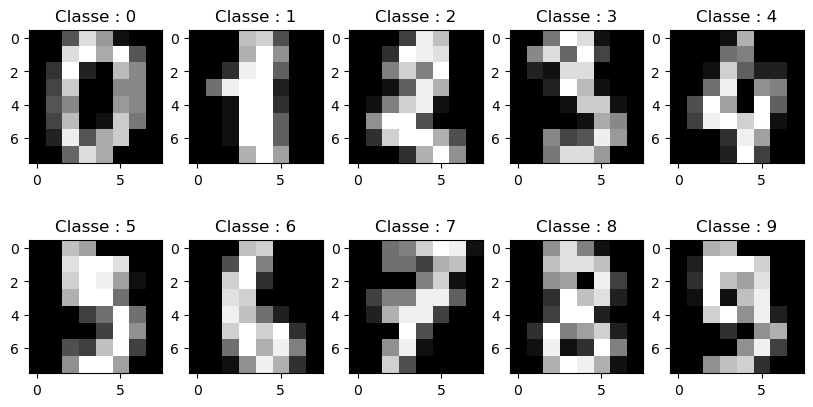

In [34]:
from matplotlib import pyplot as plt 
import seaborn as sns

# Affichez quelques images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X[i].reshape(8, 8), cmap="gray")
    ax.set_title(f"Classe : {y[i]}")
plt.show()

In [35]:
model = KMeans(n_clusters=10, n_init="auto")

In [36]:
model.fit(X)

KMeans(n_clusters=10, n_init='auto')

In [37]:
X_pred = model.predict(X)

In [42]:
X_pred

array([2, 5, 5, ..., 5, 6, 6])

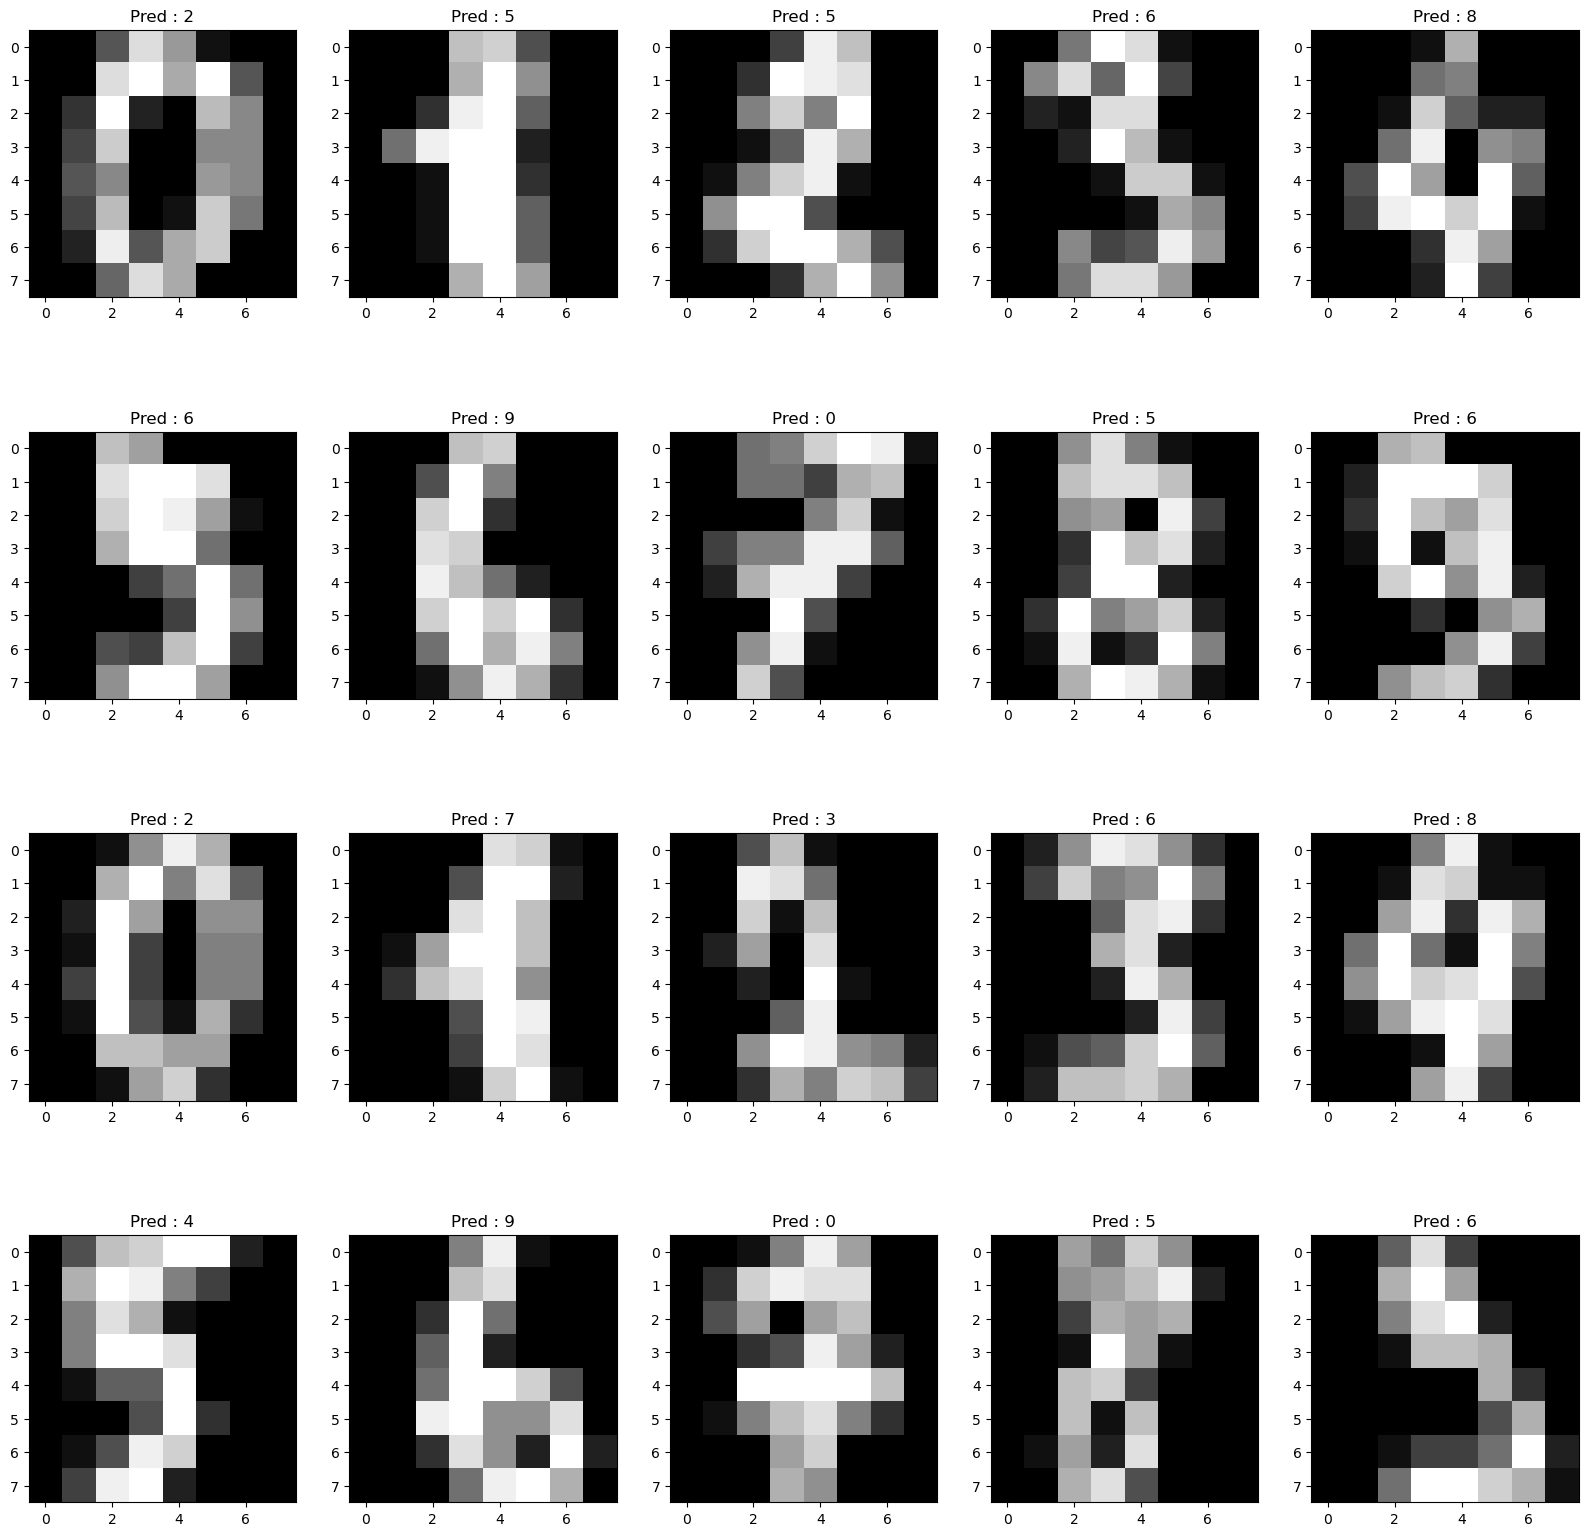

In [51]:
# Affichez quelques images
fig, axes = plt.subplots(4, 5, figsize=(20, 20))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X[i].reshape(8, 8), cmap="gray")
    ax.set_title(f"Pred : {X_pred[i]}")
plt.show()

In [39]:
metrics.rand_score(y, X_pred)

0.9146461623120941

In [40]:
metrics.adjusted_rand_score(y, X_pred)

0.5699106848416103